In [1]:
import pandas as pd 
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates

import itertools
#from pmdarima import auto_arima

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

%matplotlib inline

In [2]:
# average(median) price across time with Texas Zipcode (most expensive, least expensive)
# pull out top 10 least expensive zipcode 
# train 15 years of data 
# rmse/mse 
# baseline -> shift 
# from sklearn.model_selection import TimeSeriesSplit

In [3]:
df = pd.read_csv("time-series/zillow_data.csv")

In [4]:
df_texas = df[(df['State'] == 'TX')]
df_texas = df_texas.drop('RegionID', axis = 1)
df_texas

,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,95700.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,96100.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14372,76941,Mertzon,TX,San Angelo,Irion,14373,NaN,NaN,NaN,NaN,...,122500,121800,121600,122200,123500,124700,124300,122600,121600,121600
14472,79313,Anton,TX,Levelland,Hockley,14473,NaN,NaN,NaN,NaN,...,55400,56300,55700,56300,58900,61500,63000,63600,63500,63300
14492,79355,Plains,TX,NaN,Yoakum,14493,NaN,NaN,NaN,NaN,...,100500,100500,101000,100700,99700,97700,95800,94600,94000,93500
14599,79366,Ransom Canyon,TX,Lubbock,Lubbock,14600,134500.0,134500.0,134400.0,134400.0,...,252100,251600,251600,251500,251300,251500,251700,252500,255000,257500


In [5]:
total_plot = df.describe().drop(['RegionName', 'SizeRank', 'RegionID'], axis = 1)
index = total_plot.index
index.name = "Date"
total_plot = total_plot.T
total_plot
texas_plot = df_texas.describe().drop(['RegionName', 'SizeRank'], axis = 1)
index = texas_plot.index
index.name = "Date"
texas_plot = texas_plot.T
#texas_plot
total_plot

Date,count,mean,std,min,25%,50%,75%,max
1996-04,13684.0,118299.123063,86002.509608,11300.0,68800.0,99500.0,143200.0,3676700.0
1996-05,13684.0,118419.044139,86155.673905,11500.0,68900.0,99500.0,143300.0,3704200.0
1996-06,13684.0,118537.423268,86309.226295,11600.0,69100.0,99700.0,143225.0,3729600.0
1996-07,13684.0,118653.069278,86467.945969,11800.0,69200.0,99700.0,143225.0,3754600.0
1996-08,13684.0,118780.254312,86650.941365,11800.0,69375.0,99800.0,143500.0,3781800.0
...,...,...,...,...,...,...,...,...
2017-12,14723.0,281095.320247,367045.388033,14300.0,129900.0,193400.0,313400.0,18307100.0
2018-01,14723.0,282657.060382,369572.741938,14100.0,130600.0,194100.0,315100.0,18365900.0
2018-02,14723.0,284368.688447,371773.905107,13900.0,131050.0,195000.0,316850.0,18530400.0
2018-03,14723.0,286511.376757,372461.234695,13800.0,131950.0,196700.0,318850.0,18337700.0


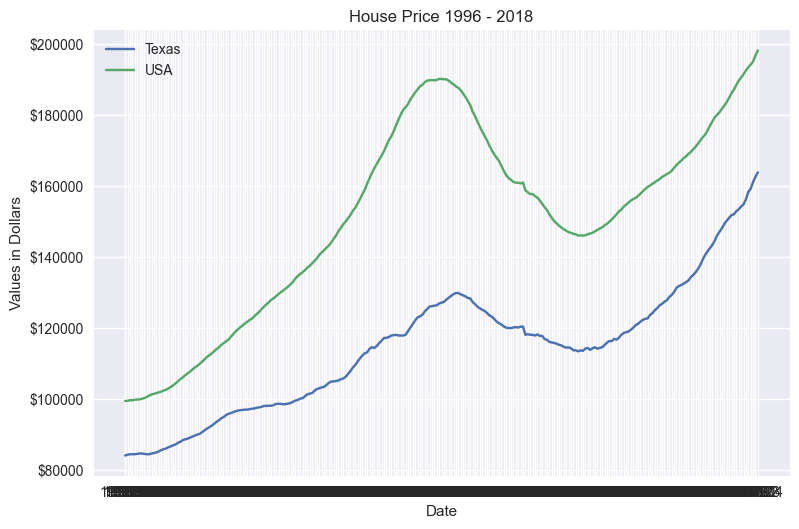

In [117]:
plt.style.use('seaborn')
date = pd.date_range(start='1996-04', end = '2018-04', freq='M').strftime('%Y-%m')
date = date.to_series()

# setting figure size to 12, 10
fig, ax = plt.subplots()
 
# Labelling the axes and setting

ax.set_xlabel("Date")
ax.set_ylabel("Values in Dollars")
ax.set_title("House Price 1996 - 2018")


ax.plot(texas_plot["50%"])
ax.plot(total_plot['50%'])
ax.legend(['Texas', 'USA'])
ax.yaxis.set_major_formatter('${x:1.0f}')
#ticks = plt.get_xticks()
#plt.xticks([tick for tick in ticks if tick%24 == 0])
#plt.x_axis.set_major_locator(mdates.YearLocator(interval=1))   #to get a tick every 15 minutes
#plt.x_axis.set_major_formatter(mdates.DateFormatter('%Y:%m'))     #optional formatting 

In [88]:
texas_stability = df_texas.copy()
date = pd.date_range(start='1996-04', end = '2007-10', freq='M').strftime('%Y-%m')
date = date.to_series()
date2 = pd.date_range(start='2007-12', end = '2011-11', freq='M').strftime('%Y-%m')
date2 = date2.to_series()
date3 = pd.date_range(start='2012-01', end = '2018-05', freq='M').strftime('%Y-%m')
date3 = date3.to_series()
texas_stability = texas_stability.drop(date, axis = 1)
texas_stability = texas_stability.drop(date2, axis = 1)
texas_stability = texas_stability.drop(date3, axis = 1)
texas_stability = texas_stability.drop(['SizeRank'], axis = 1)
texas_stability_plot = texas_stability.copy()
texas_stability_plot
texas_stability_plot['stability1'] = (texas_stability_plot['2011-11'] - texas_stability_plot['2007-10'])/texas_stability_plot['2007-10']
texas_stability_plot['stability2'] = (texas_stability_plot['2011-12'] - texas_stability_plot['2007-10'])/texas_stability_plot['2007-10']
texas_stability_plot['stability3'] = (texas_stability_plot['2011-11'] - texas_stability_plot['2007-11'])/texas_stability_plot['2007-11']
texas_stability_plot['stability4'] = (texas_stability_plot['2011-12'] - texas_stability_plot['2007-11'])/texas_stability_plot['2007-11']
texas_stability_plot['mean'] = (texas_stability_plot['stability1']+texas_stability_plot['stability2']+texas_stability_plot['stability3']+texas_stability_plot['stability4'])/4
texas_stability_plot = texas_stability_plot.dropna()
texas_stability_plot = texas_stability_plot[texas_stability_plot.RegionName < 75400]
texas_stability_plot.sort_values('stability1', ascending = False).head(20)

,RegionName,City,State,Metro,CountyName,2007-10,2007-11,2011-11,2011-12,stability1,stability2,stability3,stability4,mean
2813,75238,Dallas,TX,Dallas-Fort Worth,Dallas,225800.0,226400.0,233800.0,233200.0,0.035430,0.032772,0.032686,0.030035,3.273070e-02
1756,75028,Flower Mound,TX,Dallas-Fort Worth,Denton,218500.0,218900.0,225400.0,226000.0,0.031579,0.034325,0.029694,0.032435,3.200818e-02
995,75023,Plano,TX,Dallas-Fort Worth,Collin,170200.0,170400.0,172500.0,172400.0,0.013514,0.012926,0.012324,0.011737,1.262513e-02
757,75025,Plano,TX,Dallas-Fort Worth,Collin,232900.0,232900.0,235200.0,235100.0,0.009875,0.009446,0.009875,0.009446,9.660799e-03
820,75080,Richardson,TX,Dallas-Fort Worth,Dallas,172200.0,172700.0,172600.0,172700.0,0.002323,0.002904,-0.000579,0.000000,1.161861e-03
277,75035,Frisco,TX,Dallas-Fort Worth,Collin,238100.0,238000.0,238300.0,237800.0,0.000840,-0.001260,0.001261,-0.000840,4.411676e-08
6201,75094,Murphy,TX,Dallas-Fort Worth,Collin,258800.0,259800.0,255200.0,254800.0,-0.013910,-0.015456,-0.017706,-0.019246,-1.657945e-02
54,75287,Dallas,TX,Dallas-Fort Worth,Dallas,229800.0,228600.0,224800.0,226300.0,-0.021758,-0.015231,-0.016623,-0.010061,-1.591821e-02
10798,75182,Sunnyvale,TX,Dallas-Fort Worth,Dallas,294900.0,293600.0,287700.0,288600.0,-0.024415,-0.021363,-0.020095,-0.017030,-2.072589e-02
2535,75077,Lewisville,TX,Dallas-Fort Worth,Denton,201100.0,201900.0,195600.0,196200.0,-0.027350,-0.024366,-0.031204,-0.028232,-2.778773e-02


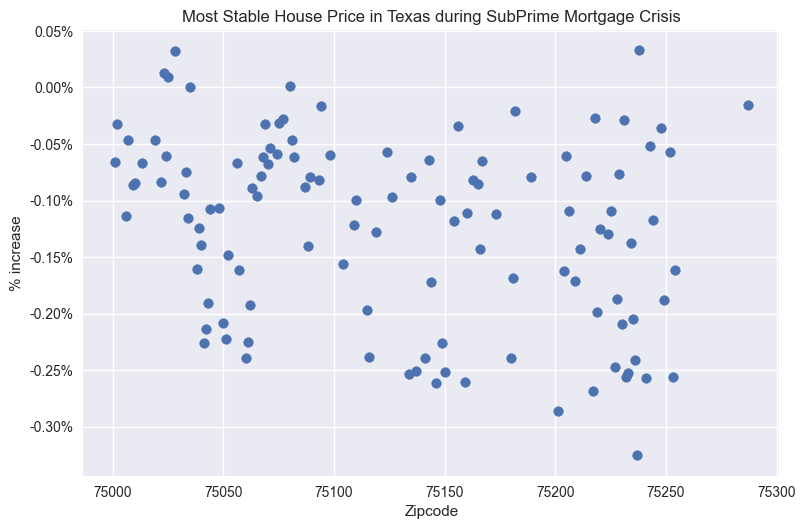

In [107]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.scatter('RegionName', 'mean', data = texas_stability_plot)
ax.set_title('Most Stable House Price in Texas during SubPrime Mortgage Crisis')
ax.set_xlabel('Zipcode')
ax.set_ylabel('% increase')
ax.yaxis.set_major_formatter('{x:0.2f}%')

In [55]:
texas_check = texas_stability.describe().T
texas_check
check = texas_check['50%'].between(100000, 114000)
sum(check)
#texas_check.index[texas_check.index==True].tolist()

2

In [84]:
date = pd.date_range(start='1996-04', end = '2018-04', freq='M').strftime('%Y-%m')

In [82]:
df2 = pd.read_csv("time-series/zillow_forecast.csv")

In [83]:
date = pd.date_range(start='2014-01', end = '2022-05', freq='M').strftime('%Y-%m')
#time_series = pd.Series(ex[date], index=date)

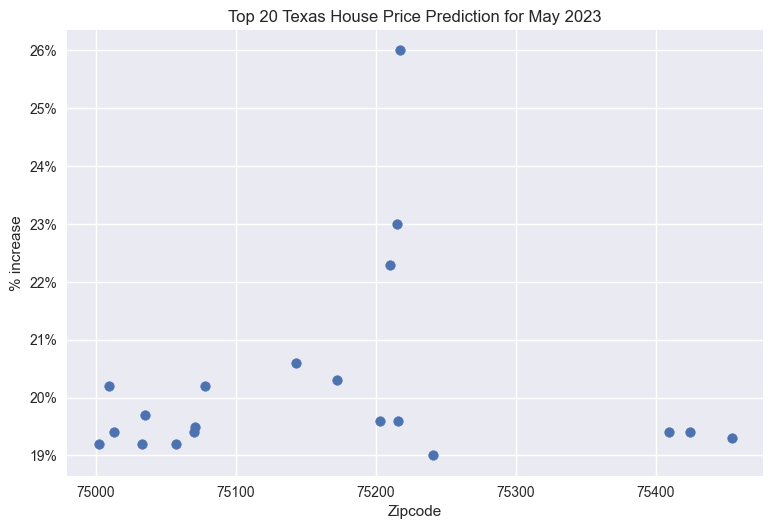

In [106]:
plt.style.use('seaborn')
f_predicted = df2.copy()
f_predicted = f_predicted[(df2['State'] == 'TX') & (df2['RegionName'] < 76400)]
#f_fixed['profit'] = (f_fixed['2023-05-31'] - f_fixed['2022-06-30'])/f_fixed['2022-06-30']
f_predicted['growth'] = f_predicted['2023-05-31'] - f_predicted['2022-06-30']
f_predicted = f_predicted.sort_values('growth', ascending=False)
f_predicted = f_predicted.iloc[:20]
f_predicted

fig, ax = plt.subplots()
ax.scatter('RegionName', 'growth', data = f_predicted)
ax.set_title('Top 20 Texas House Price Prediction for May 2023')
ax.set_xlabel('Zipcode')
ax.set_ylabel('% increase')
ax.yaxis.set_major_formatter('{x:1.0f}%')

In [ ]:
#f_fixed.drop(columns = f_fixed[['2022-06-30', '2022-08-31', '2023-05-31']].columns[(f_fixed[['2022-06-30', '2022-08-31', '2023-05-31']] > 0).any()])

indexNames = f_fixed[ f_fixed[['2022-06-30', '2022-08-31', '2023-05-31']] > 0 ].index
f_fixed.drop(indexNames , inplace=True)

f_fixed.sort_values(['2022-06-30', '2022-08-31', '2023-05-31'], ascending=True)

